In [36]:
import os
import time
import h5py
import random
import math
import operator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
random.seed(7)

## Read input data

In [37]:
# Load the train images and labels data and check the shape

with h5py.File('input/train/images_training.h5','r') as H:
    data_train = np.copy(H['datatrain'])
with h5py.File('input/train/labels_training.h5','r') as H:
    label_train = np.copy(H['labeltrain'])

print(data_train.shape,label_train.shape) #30,000 images and each image has 784 features

(30000, 784) (30000,)


In [38]:
# Load the test images and labels data and check the shape 
# as followed the instruction that using H['datatest'], H['labeltest'] for test dataset

with h5py.File('input/test/images_testing.h5','r') as H:
    data_test = np.copy(H['datatest'])
with h5py.File('input/test/labels_testing_2000.h5','r') as H:
    label_test = np.copy(H['labeltest'])
    
print(data_test.shape,label_test.shape) #10,000 test examples, 2000 of them have labels

(10000, 784) (2000,)


## Naive Bayes Implementation

In [65]:
import random
import math

# Handle data : split the data set randomly

def split_dataset(dataset, split_ratio):
    train_size = int(len(dataset) * split_ratio)
    train_set = []
    copy = list(dataset)
    while len(train_set) < train_size:
        index = random.randrange(len(copy))
        train_set.append(copy.pop(index))
    return [np.array(train_set), np.array(copy)]

def separateByClass(dataset):
    separated = {}
    for i in range(len(dataset)):
        vector = dataset[i]
        if (vector[-1] not in separated):
            separated[vector[-1]] = []
        separated[vector[-1]].append(vector)
    return separated

#def mean(numbers):
#    return sum(numbers)/float(len(numbers))

def stdev(numbers):
    avg = mean(numbers)
    variance = sum([pow(x-avg,2) for x in numbers])/float(len(numbers)-1)
    return math.sqrt(variance)

def summarize(dataset):
    summaries = [(mean(attribute), stdev(attribute)) for attribute in zip(*dataset)]
    del summaries[-1]
    return summaries

def summarizeByClass(dataset):
    separated = separateByClass(dataset)
    summaries = {}
    for classValue, instances in separated.items():
        summaries[classValue] = summarize(instances)
    return summaries

def calculateProbability(x, mean, stdev):
    exponent = math.exp(-(math.pow(x-mean,2)/(2*math.pow(stdev,2))))
    return (1 / (math.sqrt(2*math.pi) * stdev)) * exponent

def calculateClassProbabilities(summaries, inputVector):
    probabilities = {}
    for classValue, classSummaries in summaries.items():
        probabilities[classValue] = 1
        for i in range(len(classSummaries)):
            mean, stdev = classSummaries[i]
            x = inputVector[i]
            probabilities[classValue] *= calculateProbability(x, mean, stdev)
    return probabilities

def predict(summaries, inputVector):
    probabilities = calculateClassProbabilities(summaries, inputVector)
    bestLabel, bestProb = None, -1
    for classValue, probability in probabilities.items():
        if bestLabel is None or probability > bestProb:
            bestProb = probability
            bestLabel = classValue
    return bestLabel

def getPredictions(summaries, testSet):
    predictions = []
    for i in range(len(testSet)):
        result = predict(summaries, testSet[i])
        predictions.append(result)
    return predictions

def getAccuracy(testSet, predictions):
    correct = 0
    for i in range(len(testSet)):
        if testSet[i][-1] == predictions[i]:
            correct += 1
    return (correct/float(len(testSet))) * 100.0

def concat_array(x, y):
    return np.concatenate((x, np.reshape(y, (len(y), 1))), axis=1)

## PCA Implementation

In [56]:
# Create PCA space and projection of new data points

from numpy import mean
from numpy import cov
from numpy.linalg import eig

def pca(x_train, component):

    # calculate the mean of each column
    M = mean(x_train.T, axis=1)
    # center columns by subtracting column means
    C = x_train - M
    # calculate covariance matrix of centered matrix
    V = cov(C.T)
    
    # eigendecomposition of covariance matrix
    values, vectors = eig(V)

    # Make a list of (eigenvalue, eigenvector) tuples
    eig_pairs = [(np.abs(values[i]), vectors[:,i]) for i in range(len(vectors))]

    # Sort the (eigenvalue, eigenvector) tuples from high to low
    eig_pairs.sort(key=lambda x: x[0], reverse=True)

    tot = sum(values)
    var_exp = [(i / tot)*100 for i in sorted(values, reverse=True)]
    cum_var_exp = np.cumsum(var_exp)
    #print("Variance captured by each component is \n",var_exp[0:50])
    #print(40 * '-')
    print("Cumulative variance captured at component number", component, "is",cum_var_exp[component],"%\n")
    
    
    plt.plot(list(range(1,len(cum_var_exp)+1)), cum_var_exp)
    plt.xlabel('PCA Component')
    plt.ylabel('Cumulative Var explained')

    P = C.dot(vectors[:,0:component])
    return [P, vectors[:,0:component]]
    
def projection(new, vectors):
    # calculate the mean of each column
    M = mean(new.T, axis=1)
    # center columns by subtracting column means
    C = new - M
    P = C.dot(vectors)
    return P

In [53]:
# Confusion Matrix : Calculate and show the confusion matrix

def calc_confusionmatrix(x_test, y_pred):
    labels=np.unique(y_pred)
    K = len(labels)
    confusionmatrix = np.zeros((K, K))
    
    for i in range(len(y_pred)):
        confusionmatrix[int(x_test[i][-1])][int(y_pred[i])] +=1
    
    return confusionmatrix

def show_confusionmatrix_graph(confusionmatrix):
    fig, ax = plt.subplots()
    im = ax.imshow(confusionmatrix, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    plt.show()

## Discretization with pandas

In [128]:
import pandas as pd
import numpy as np

def discretize(dataset):
    result_array = np.empty((0, dataset.shape[0]))
    
    # lines are the columns in this case 50 line needed to be appended
    for line in dataset.T:
        # create new to be new line with categorical range
        new = pd.cut(line, bins=10, labels=False)
        result_array = np.append(result_array, [new], axis=0)
        
    return result_array.T

## Run predictions

Cumulative variance captured at component number 50 is 86.42872569897725 %

pca train shape:  (24000, 50)
pca test shape:  (6000, 50) 

Validation accuracy: 78.25 %
Running duration: 6.605255365371704 seconds
(6000,)


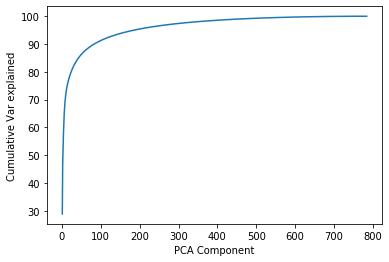

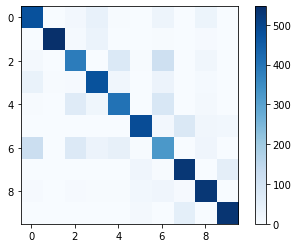

In [129]:
def run_training(x_train, y_train):
    
    data_set = concat_array(x_train, y_train)
    split_ratio = 0.8
    training_set, test_set = split_dataset(data_set, split_ratio)
    
    # Apply pca with training set using 50 components
    train, vectors = pca(training_set[:,0:-1], 50)
    print("pca train shape: ",train.shape)
    
    #train = discretize(train)
    #print("discretize train shape:", train.shape)
    
    # projection of new data onto pca
    test = projection(test_set[:,0:-1], vectors)
    print("pca test shape: ",test.shape, "\n")
    
    #test = discretize(test)
    #print("discretize test shape:", test.shape)
    
    train = concat_array(train, training_set[:,-1])
    test = concat_array(test, test_set[:,-1])
    
    start = time.time()
    summaries = summarizeByClass(train)
    predictions = getPredictions(summaries, test)
    end = time.time()

    # get accuracy of the predictions
    accuracy = getAccuracy(test_set, predictions)
    print('Validation accuracy: ' + repr(accuracy), '%')
    print('Running duration: ' + repr(end - start), "seconds")
    
    label = np.asarray(predictions)
    print(label.shape)
    
    show_confusionmatrix_graph(calc_confusionmatrix(test_set, predictions))

run_training(
    data_train, 
    label_train
)

In [130]:
# assume output is the predicted labels
# (5000,) 
def output_result(output):
    with h5py.File('output/predicted_labels.h5','w') as H:
        H.create_dataset('output',data=output)

    print(output)

Cumulative variance captured at component number 50 is 86.40140010931123 %

pca train shape:  (30000, 50)
pca test shape:  (5000, 50) 

Test accuracy on 2k test samples: 76.35%
Running duration: 6.0223143100738525seconds
(5000,)
[1. 0. 9. ... 5. 3. 5.]


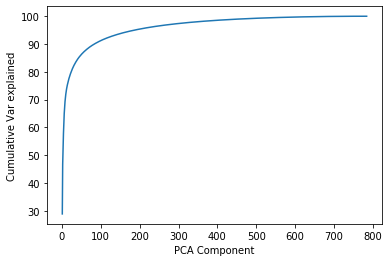

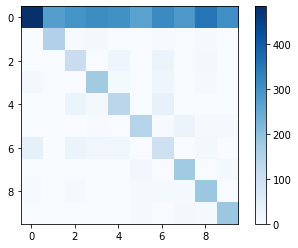

In [131]:
# run testing with 30k train and 2k test data set
def run_testing(x_train, y_train, x_test, y_test):
    # pca the 30k dataset using 50 components
    # train variables = the pca matrix output
    # vectors = eigen vectors of from the pca
    train, vectors = pca(x_train, 50)
    print("pca train shape: ",train.shape)
    
    # projection of 5k new data onto pca
    test = projection(x_test, vectors)
    print("pca test shape: ",test.shape, "\n")
    
    train = concat_array(train, y_train)
    # fill the label array with 0 for the 8k unlabeled samples
    test = concat_array(test, np.pad(y_test, (0, 3000), 'constant'))

    # Train 30k and make prediction on 10k test samples
    start = time.time()
    summaries = summarizeByClass(train)
    predictions = getPredictions(summaries, test)
    end = time.time()
    
    # get accuracy of the 1st 2k test predictions
    accuracy = getAccuracy(test[0:2000], predictions[0:2000])
    print('Test accuracy on 2k test samples: ' + repr(accuracy) + '%')
    print('Running duration: ' + repr(end - start) + "seconds")
    
    
    label = np.asarray(predictions)
    print(label.shape)
    # output the predict array
    output_result(label) 
    show_confusionmatrix_graph(calc_confusionmatrix(test, predictions))
    
run_testing(
    data_train, 
    label_train, 
    data_test[0:5000], 
    label_test[0:5000]
)

In [132]:
# cross check the output file

# Open and read the printed output
with h5py.File('./output/predicted_labels.h5','r') as H:
    test_result_label = np.copy(H['output'])
    
print(test_result_label.shape)
print(test_result_label)

(5000,)
[1. 0. 9. ... 5. 3. 5.]


## The end